In [1]:
import os
from glob import glob
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

from IPython.display import display

In [10]:
import src.elevation as elevation
import src.clean as clean
import src.plot as plot

In [3]:
# Paths
shapefile_bisse = os.path.join("data", "bisses_geodata", "bisses.shp")
dem_folder = os.path.join("data", "DEM")  # Folder containing multiple DEM files
data = "data"

sample_direction = 'debut_fin' # ou 'fin_debut'

# ! read from json file
# path of file from field results
PATH = os.path.join(data, "bisses")

folders = [f.path for f in os.scandir(PATH) if f.is_dir()]
files = [y for x in os.walk(PATH) for y in glob(os.path.join(x[0], '*.json'))]
filenames = [Path(path).stem for path in files]

# ! check if file is missing for a folder
# all bisse where data has been collected in a json
bisses_dict = dict(zip(filenames, files))

# this is the variable the interface will change
bisse_select = 'clavau'

with open(bisses_dict[bisse_select], 'r') as file:
    bisse_json = json.load(file)

#display(bisse_json)
#bisse_json = bisses_json[bisse_select]



In [4]:
# Load the line shapefile
bisses_gdf = gpd.read_file(shapefile_bisse).to_crs('EPSG:2056') # to swiss projection

# get only the bisse we want
bisse_select_gdf = bisses_gdf[bisses_gdf['Nom_bisse'] == bisse_json['nom_imventaire']]
# extract the linestring
bisse_line = bisse_select_gdf.loc[:, 'geometry'].iloc[0]

bisse_profile = elevation.get_elevation_profile(bisse_line, dem_folder=dem_folder)

# cleaning data referenced in json

In [5]:
path_clavau = os.path.normpath('data/bisses/clavau')

#! need to do that for all couches
clean.clean_list_json(bisse_json['liste_touristique'], path_clavau, 'data/bisses/clavau/touristique', bisse_line)
clean.clean_list_json(bisse_json['liste_environnement'], path_clavau, 'data/bisses/clavau/environnement', bisse_line)

d:\Programme\miniconda3\envs\bisses\Lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'PointM' is converted to 'Point'
  return ogr_read(


# plotting

In [9]:
import random

with open(os.path.join('data/bisses/clavau/environnement', 'plot.json'), 'r') as file:
    plot_env = json.load(file)

with open(os.path.join('data/bisses/clavau/touristique', 'plot.json'), 'r') as file:
    plot_tour = json.load(file)

to_plot = []
to_plot.append(random.sample(list(plot_env.values()), k=1))
to_plot.append(random.sample(list(plot_tour.values()), k=1))
to_plot = [
    x
    for xs in to_plot
    for x in xs
]
print(to_plot)

[{'nom_indice': 'Biotopes', 'type_donnee': 'section', 'format_donnee': 'categorie', 'path': 'data\\bisses\\clavau\\environnement\\Biotopes\\biotope.csv'}, {'nom_indice': 'Panneaux information', 'type_donnee': 'point', 'format_donnee': 'categorie', 'path': 'data\\bisses\\clavau\\touristique\\Panneaux information\\didact.csv'}]


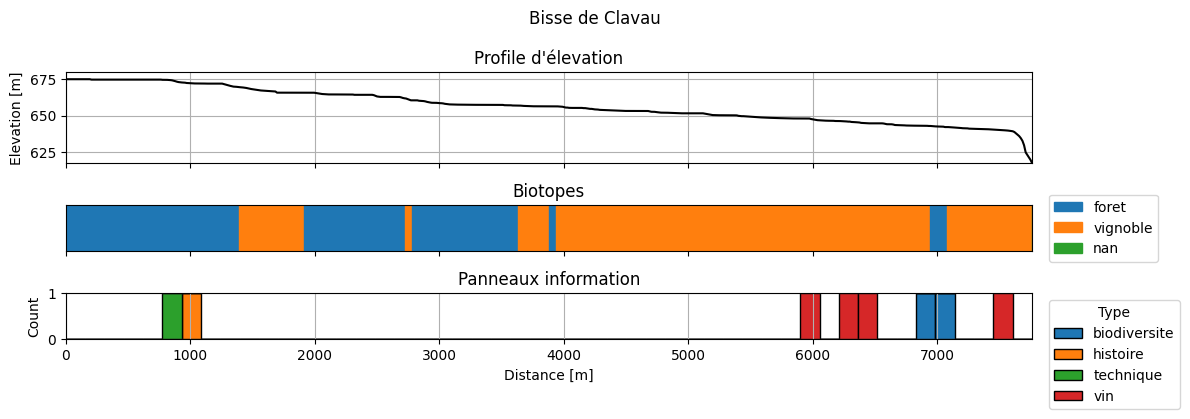

In [12]:
number_of_functions = 2

height_ratio = {'height_ratios': [2] + [1]*number_of_functions}
fig, axs = plt.subplots(nrows=number_of_functions+1, figsize=(12, 2*number_of_functions), sharex=True, gridspec_kw=height_ratio)

plot.plot_elevation(axs[0], bisse_profile)
axs[0].set_title('Profile d\'élevation')

for i, indicateur in enumerate(to_plot):
    data = pd.read_csv(indicateur['path'])

    if indicateur['type_donnee'] == 'section':
        plot.plot_sections(axs[i+1], bisse_profile, data)
    elif indicateur['type_donnee'] == 'point':
        plot.plot_point_data(axs[i+1], bisse_profile, data, num_bins=50)
    elif indicateur['type_donnee'] == 'autre':
        print('cant find implementation of plot for that type of data')

    axs[i+1].set_title(indicateur['nom_indice'])

axs[-1].set_xlabel("Distance [m]")

fig.suptitle('Bisse de Clavau')
plt.tight_layout()
plt.show()